# 감성분석 결과와 주가 데이터 비교

## 감성분석 결과 데이터프레임

In [1]:
import koreanize_matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

months = ['1월', '2월', '3월', '4월', '5월', '6월',
           '7월', '8월', '9월', '10월', '11월', '12월']
company = "삼성전자"

sentiment_result = pd.read_csv("../data/project/predicted_삼성전자_2023.csv") # 감성분석 결과 csv파일 읽어오기
sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result['month'] = sentiment_result['date'].dt.month

sentiments_data = []

for index, row in sentiment_result.iterrows():
    
    month = row['month']
    prediction = row['prediction']
    score = row['score']
   
    sentiments_data.append([month, company, prediction, score])

sentiments_df = pd.DataFrame(sentiments_data, columns=['month', 'company', 'prediction', 'score'])
sentiments_df

,month,company,prediction,score
0,1,삼성전자,호재,2.949686
1,1,삼성전자,호재,6.362477
2,1,삼성전자,호재,5.188083
3,1,삼성전자,악재,6.192028
4,1,삼성전자,중립,5.007812
...,...,...,...,...
6456,12,삼성전자,호재,5.736773
6457,12,삼성전자,중립,5.329077
6458,12,삼성전자,호재,6.616199
6459,12,삼성전자,호재,6.603549


In [2]:
# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df['total'] = sentiments_df['prediction'].map(weights) * sentiments_df['score']
sentiments_df['month'] = sentiments_df['month'].astype(str) + '월'

df_monthly_total = sentiments_df.groupby(['month', 'company'])['total'].sum().unstack()
df_monthly_total = df_monthly_total.reindex(months)

df_monthly_total

company,삼성전자
month,
1월,-392.151479
2월,-219.816006
3월,377.953342
4월,-503.363980
5월,616.028683
6월,939.939568
7월,312.755958
8월,302.089980
9월,438.592495


In [3]:
sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461 entries, 0 to 6460
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       6461 non-null   object 
 1   company     6461 non-null   object 
 2   prediction  6461 non-null   object 
 3   score       6461 non-null   float64
 4   total       6461 non-null   float64
dtypes: float64(2), object(3)
memory usage: 252.5+ KB


In [4]:
import FinanceDataReader as fdr

df_krx = fdr.StockListing('KRX')
samsung = df_krx[df_krx["Name"].isin(["삼성전자"])]
samsung

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,75200,1,100,0.13,75700,75800,74300,14756181,1106952682800,448927647760000,5969782550,STK


In [5]:
ds_stock = fdr.DataReader('005930', '2023-01-01', '2023-12-31')
ds_stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617
2023-01-03,55400,56000,54500,55400,13547030,-0.001802
2023-01-04,55700,58000,55600,57800,20188071,0.043321
2023-01-05,58200,58800,57600,58200,15682826,0.006920
2023-01-06,58300,59400,57900,59000,17334989,0.013746


## 감성분석 결과 시각화

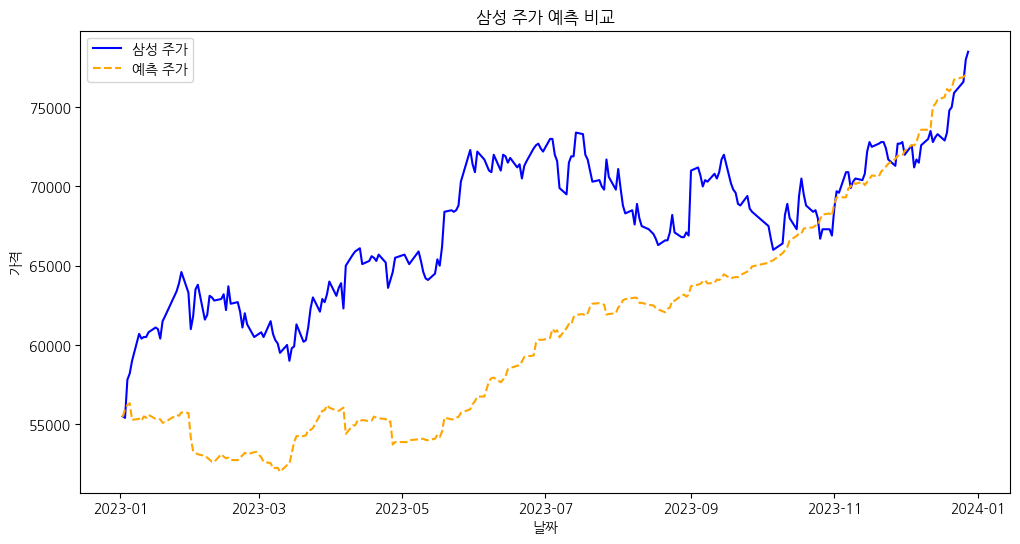

In [6]:
import random
import koreanize_matplotlib
from datetime import datetime, timedelta
import FinanceDataReader as fdr

company = "삼성전자"

sentiment_result = pd.read_csv("../data/project/predicted_삼성전자_2023.csv") # 감성분석 결과 csv파일 읽어오기

sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result["date"] = sentiment_result["date"].dt.date

sentiments_data = []

for index, row in sentiment_result.iterrows():
    date = row['date']
    prediction = row['prediction']
    score = row['score']
    sentiments_data.append([date, company, prediction, score])

sentiments_df2 = pd.DataFrame(sentiments_data, columns=['date', 'company', 'prediction', 'score'])

# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df2['total'] = sentiments_df2['prediction'].map(weights) * sentiments_df2['score']

df_ss = sentiments_df2.groupby(['date', 'company']).agg({'total': 'sum'}).reset_index()
df_ss['date'] = pd.to_datetime(df_ss['date'])
df_ss = df_ss.set_index('date')

# 주가 데이터에 감성분석 결과 총점 추가
ss_stock = fdr.DataReader('005930', '2023-01-01', '2023-12-31')
ss_stock['Sentiment_Total'] = df_ss['total']
ss_stock['Sentiment_Total'] = ss_stock['Sentiment_Total'].fillna(0)

# 감성분석 결과 Scaling
scaling_factor = 5
ss_stock['Sentiment_Total'] = ss_stock['Sentiment_Total'] * scaling_factor

# 누적 합 계산
ss_stock['Sentiment_Total_Cumulative'] = ss_stock['Sentiment_Total'].cumsum()

# 오프셋 설정
offset = 55500
ss_stock['Sentiment_Total_Cumulative_Offset'] = ss_stock['Sentiment_Total_Cumulative'] + offset

plt.figure(figsize=(12, 6))
plt.plot(ss_stock['Close'], label='삼성 주가', color='blue')
plt.plot(ss_stock['Sentiment_Total_Cumulative_Offset'], label='예측 주가', linestyle='--', color='orange')
plt.title('삼성 주가 예측 비교')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.show()

In [7]:
ss_stock

,Open,High,Low,Close,Volume,Change,Sentiment_Total,Sentiment_Total_Cumulative,Sentiment_Total_Cumulative_Offset
Date,,,,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617,-43.207459,-43.207459,55456.792541
2023-01-03,55400,56000,54500,55400,13547030,-0.001802,505.974786,462.767327,55962.767327
2023-01-04,55700,58000,55600,57800,20188071,0.043321,245.847194,708.614521,56208.614521
2023-01-05,58200,58800,57600,58200,15682826,0.006920,119.389336,828.003857,56328.003857
2023-01-06,58300,59400,57900,59000,17334989,0.013746,-1055.233812,-227.229955,55272.770045
...,...,...,...,...,...,...,...,...,...
2023-12-21,74600,75000,74300,75000,13478766,0.002674,191.200926,20701.547687,76201.547687
2023-12-22,75800,76300,75400,75900,14515608,0.012000,540.927731,21242.475418,76742.475418
2023-12-26,76100,76700,75700,76600,13164909,0.009223,157.495108,21399.970526,76899.970526


### 감성분석 결과 기반 경향선과 주가 데이터 최적경향선 비교

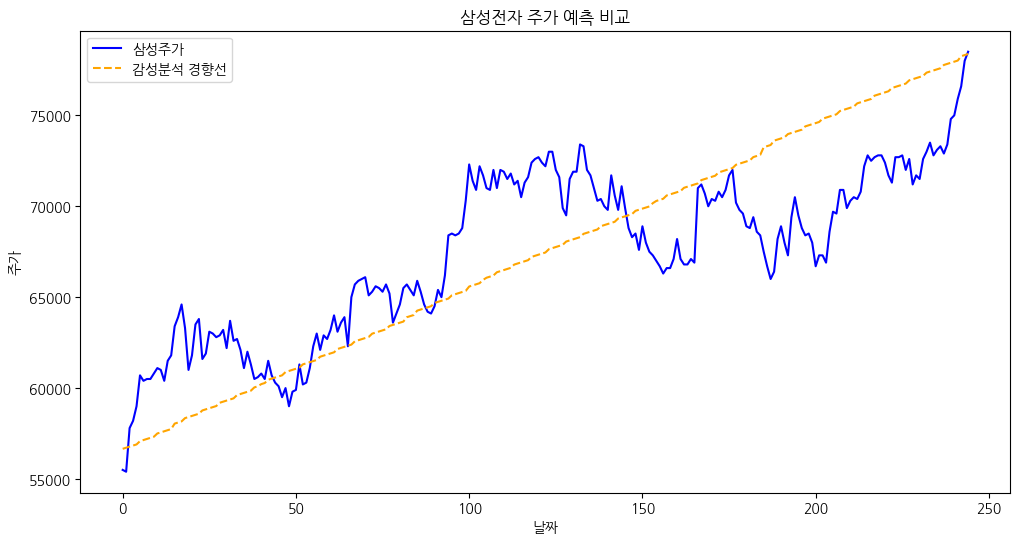

In [8]:
import FinanceDataReader as fdr
import seaborn as sns
import matplotlib.pyplot as plt

# 주가 데이터 가져오기
ss_stock = fdr.DataReader('005930', '2023-01-01', '2023-12-31')

# 감성분석 결과의 크기를 조절
scaling_factor = 5
df_ss['Sentiment_Total'] = df_ss['total'] * scaling_factor

ss_stock = ss_stock.sort_index()
df_ss = df_ss.sort_index()

# 날짜를 일로 나타내는 정수로 변환
ss_stock['Date_Integer'] = (ss_stock.index - ss_stock.index.min()).days
df_ss['Date_Integer'] = (df_ss.index - df_ss.index.min()).days

# 주식 데이터와 감성분석 결과 날짜기준 병합
merged_data = pd.merge(ss_stock, df_ss, left_on='Date_Integer', right_on='Date_Integer', how='left')

# 결측치 처리
merged_data['Sentiment_Total'] = merged_data['Sentiment_Total'].fillna(0)

# 감성분석 결과기반 1차 함수의 계수 및 y값 계산
coeff = np.polyfit(merged_data['Date_Integer'], merged_data['Sentiment_Total'].cumsum(), 1)
merged_data['Sentiment_Linear'] = np.polyval(coeff, merged_data['Date_Integer'])

# 오프셋 설정
offset = merged_data['Close'].mean() - merged_data['Sentiment_Linear'].iloc[len(merged_data) // 2]
merged_data['Sentiment_Linear_Offset'] = merged_data['Sentiment_Linear'] + offset

plt.figure(figsize=(12, 6))
plt.plot(merged_data['Close'], label='삼성주가', color='blue')
plt.plot(merged_data['Sentiment_Linear_Offset'], label='감성분석 경향선', linestyle='--', color='orange')
plt.title('삼성전자 주가 예측 비교')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.show()


In [9]:
import pandas as pd
import cufflinks as cf
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
cf.set_config_file(theme='pearl', world_readable=False)
cf.go_offline()
single_stock = fdr.DataReader('005930', '2023-01-01', '2023-12-31')
single_stock['Close'].iplot(title='삼성전자 최적경향선', bestfit=True, bestfit_colors=['blue']) # 수익률 시각화, bestfit:최적 경향선 추가(추세 파악 용이)

# 상관분석

In [10]:
ss_stock.index = pd.to_datetime(ss_stock.index)

# 월별 평균 수익률 계산
monthly_avg_returns = ss_stock['Close'].resample('M').mean().pct_change()

print(monthly_avg_returns)

Date
2023-01-31         NaN
2023-02-28    0.029402
2023-03-31   -0.018847
2023-04-30    0.060668
2023-05-31    0.031532
2023-06-30    0.071393
2023-07-31   -0.004584
2023-08-31   -0.051316
2023-09-30    0.036670
2023-10-31   -0.032178
2023-11-30    0.051517
2023-12-31    0.033629
Freq: M, Name: Close, dtype: float64


In [11]:
ss_stock

,Open,High,Low,Close,Volume,Change,Date_Integer
Date,,,,,,,
2023-01-02,55500,56100,55200,55500,10031448,0.003617,0
2023-01-03,55400,56000,54500,55400,13547030,-0.001802,1
2023-01-04,55700,58000,55600,57800,20188071,0.043321,2
2023-01-05,58200,58800,57600,58200,15682826,0.006920,3
2023-01-06,58300,59400,57900,59000,17334989,0.013746,4
...,...,...,...,...,...,...,...
2023-12-21,74600,75000,74300,75000,13478766,0.002674,353
2023-12-22,75800,76300,75400,75900,14515608,0.012000,354
2023-12-26,76100,76700,75700,76600,13164909,0.009223,358


In [12]:
company = "삼성전자"

sentiment_result = pd.read_csv("../data/project/predicted_삼성전자_2023.csv") # 감성분석 결과 csv파일 읽어오기
sentiment_result['date'] = pd.to_datetime(sentiment_result['date'])
sentiment_result['month'] = sentiment_result['date'].dt.month

sentiments_data = []

for index, row in sentiment_result.iterrows():
    
    month = row['month']
    prediction = row['prediction']
    score = row['score']
   
    sentiments_data.append([month, company, prediction, score])

sentiments_df = pd.DataFrame(sentiments_data, columns=['month', 'company', 'prediction', 'score'])

# 감성에 따른 가중치 매핑
weights = {'호재': 1, '악재': -1, '중립': 0}
sentiments_df['total'] = sentiments_df['prediction'].map(weights) * sentiments_df['score']
sentiments_df = sentiments_df.drop('company', axis=1)
sentiments_df = sentiments_df.rename(columns={'삼성전자': 'total'})
sentiments_df['month'] = sentiments_df['month'].astype(str) + '월'

# 'month' 기준 그룹화 및 합계
df_monthly_total = sentiments_df.groupby('month')['total'].sum().reset_index()

df_monthly_total['month'] = pd.Categorical(df_monthly_total['month'], categories=['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'], ordered=True)
df_monthly_total = df_monthly_total.sort_values('month')
df_monthly_total = df_monthly_total.reset_index(drop=True)

# 월별 감성분석 변동
monthly_avg_total = df_monthly_total['total']
monthly_avg_total_diff = monthly_avg_total.pct_change()

print(monthly_avg_total_diff)


0          NaN
1    -0.439461
2    -2.719408
3    -2.331815
4    -2.223824
5     0.525805
6    -0.667260
7    -0.034103
8     0.451860
9     0.798440
10    0.081964
11    0.390637
Name: total, dtype: float64


In [13]:
sentiment_predicted_diff = monthly_avg_total_diff.tolist()
month_avg_gain = monthly_avg_returns.tolist()

if pd.isna(month_avg_gain[0]):
    month_avg_gain = month_avg_gain[1:]
    sentiment_predicted_diff = sentiment_predicted_diff[1:]


In [14]:
import numpy as np
import scipy.stats

# 두 리스트 간의 상관 계수 계산
correlation_coefficient, p_value = scipy.stats.pearsonr(sentiment_predicted_diff, month_avg_gain)

print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Statistically significant correlation.")
else:
    print("No statistically significant correlation.")

Correlation Coefficient: -0.012050343190822651
P-value: 0.971949029542867
No statistically significant correlation.


In [15]:
import pandas as pd

correlation_data = pd.DataFrame({'월별 평균 수익률 변동': month_avg_gain, '월별 감성분석 변동': sentiment_predicted_diff})

# 상관 행렬
correlation_matrix = correlation_data.corr()

print(correlation_matrix)

              월별 평균 수익률 변동  월별 감성분석 변동
월별 평균 수익률 변동       1.00000    -0.01205
월별 감성분석 변동        -0.01205     1.00000


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에 인덱스 설정
index_months = [str(i) + '월' for i in range(2, 13)]
correlation_data.index = index_months

correlation_data


,월별 평균 수익률 변동,월별 감성분석 변동
2월,0.029402,-0.439461
3월,-0.018847,-2.719408
4월,0.060668,-2.331815
5월,0.031532,-2.223824
6월,0.071393,0.525805
7월,-0.004584,-0.667260
8월,-0.051316,-0.034103
9월,0.036670,0.451860
10월,-0.032178,0.798440
11월,0.051517,0.081964


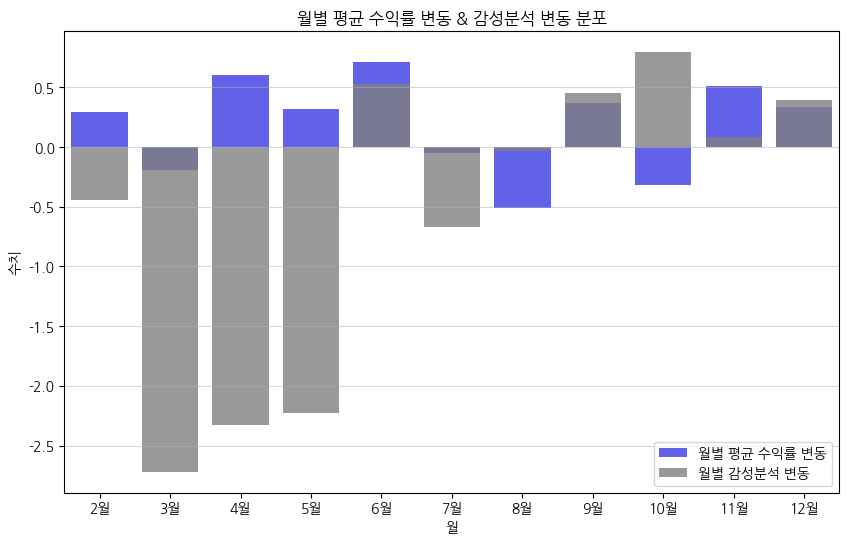

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 월별 평균 수익률 변동에 적절한 가중치 설정
correlation_data['월별 평균 수익률 변동'] = correlation_data['월별 평균 수익률 변동'] * 10

# 히스토그램
plt.figure(figsize=(10, 6))
plt.grid(axis='y', which='major', alpha=0.5)
sns.barplot(x=index_months, y='월별 평균 수익률 변동', data=correlation_data, alpha=0.7, label='월별 평균 수익률 변동', color='Blue')
sns.barplot(x=index_months, y='월별 감성분석 변동', data=correlation_data, alpha=0.8, label='월별 감성분석 변동', color = 'Gray')
plt.title('월별 평균 수익률 변동 & 감성분석 변동 분포')
plt.xlabel('월')
plt.ylabel('수치')
plt.legend()
plt.show()